## 滴滴出行A/B测试&城市运营分析

#### 问题背景
随着企业日常经营活动的进行，企业内部必然产生了各式各样的数据，如何利用这些数据得出有益的见解，并支持我们下一步的产品迭代以及领导决策就显得尤为重要。

A/B测试是互联网企业常用的一种基于数据的产品迭代方法，它的主要思想是控制其他条件不变的前提下对不同（或同一、同质）样本设计不同实验水平（方案），并根据最终的数据变现来判断自变量对因变量的影响，其主要理论思想来源于统计学的假设检验部分；

#### 数据说明
- 数据集分为test.xlsx 与 city.xlsx 两部分：
- 其中test.xlsx 为滴滴出行某次AB测试结果数据，各字段说明如下：

| 字段名称          | 字段解释       |
| ----------------- | -------------- |
| date              | 日期           |
| group             | 组别           |
| requests          | 订单请求数     |
| gmv               | 成交总额       |
| coupon per trip   | 每单优惠券金额 |
| trips             | 订单数         |
| canceled requests | 取消请求数     |

- city.xlsx 为某城市运营数据，各字段说明如下：

| 字段名称                 | 字段解释             |
| ------------------------ | -------------------- |
| date                     | 日期                 |
| hour                     | 时点                 |
| requests                 | 订单请求数           |
| trips                    | 订单数               |
| supply hours             | 可服务时长           |
| average minutes of trips | 平均订单时长（分钟） |
| pETA                     | 顾客预计等待时长     |
| aETA                     | 顾客实际等待时长     |
| utiliz                   | 司机在忙率           |

- test.xlsx 数据可以用来判断实验条件对此次AB测试的结果影响是否显著；
- city.xlsx 数据可以用来探索该城市运营中出现的问题，根据关键结论辅助决策。

#### 数据来源
- 数据来自滴滴出行内部

### 一、A/B测试效果分析

#### 1、数据准备

In [2]:
import pandas as pd

test = pd.read_excel('./data/test.xlsx')
test.head()

,date,group,requests,gmv,coupon per trip,trips,canceled requests
0,2019-01-01,control,30,7486.620,1.069746,24,1
1,2019-01-02,control,152,38301.575,1.044199,121,8
2,2019-01-03,control,267,67768.425,1.032276,215,14
3,2019-01-04,control,369,94992.900,1.028196,298,19
4,2019-01-05,control,478,123236.875,1.011807,390,24


#### 2、计算ROI

In [5]:
# 计算优惠券投入相对gmv的ROI
test['ROI'] = test['gmv']/(test['coupon per trip']*test['trips'])
test.head()

,date,group,requests,gmv,coupon per trip,trips,canceled requests,ROI
0,2019-01-01,control,30,7486.620,1.069746,24,1,291.604269
1,2019-01-02,control,152,38301.575,1.044199,121,8,303.143166
2,2019-01-03,control,267,67768.425,1.032276,215,14,305.346684
3,2019-01-04,control,369,94992.900,1.028196,298,19,310.026761
4,2019-01-05,control,478,123236.875,1.011807,390,24,312.304607


#### 3、【requests因变量】检验

In [8]:
test.groupby('group').group.count()

group
control       29
experiment    29
Name: group, dtype: int64

数据共58条，对照组和实验组各29条，样本量<30

##### (1) 【requests因变量】方差检验

- 1、记两组requests方差分别为c1, c2
- 2、零假设H0:c1=c2；备择假设H1:c1≠c2
- 3、显著性水平0.05

In [9]:
# levene检验 requests因变量 是否满足方差齐性
requests_A = test[test.group == 'control'].requests
requests_B = test[test.group == 'experiment'].requests

import scipy.stats as st
st.levene(requests_A, requests_B)

LeveneResult(statistic=0.014685075667736849, pvalue=0.903980667108546)

- P值大于0.05，不拒绝原假设，因此可认为两组实验requests因变量 齐方差

##### (2) 【requests因变量】均值检验
- 1、该数据为同一样本实验前后的不同水平，因此选用配对样本t检验。
- 2、记两组requests均值分别为u1、u2
- 3、零假设H0：u1=u2; 备择假设H1：u1≠u2
- 4、显著性水平取0.05

In [10]:
# 配对样本t检验（两独立样本t检验之前需检验是否齐方差，此处不需要）
st.ttest_rel(requests_A, requests_B)

TtestResult(statistic=1.6436140982479508, pvalue=0.11143970454099938, df=28)

- P值大于0.05，不拒绝原假设，因此可认为实验条件对requests影响不显著。

#### 4、【gmv变量】 检验

同理，对gmv进行方差和均值检验。

##### (1) 【gmv变量】方差检验

In [11]:
# levene检验gmv方差是否齐性
gmv_A = test[test.group == 'control'].gmv
gmv_B = test[test.group == 'experiment'].gmv

st.levene(gmv_A, gmv_B)

LeveneResult(statistic=0.02865341299111212, pvalue=0.8661917430097603)

- P值大于0.05，不拒绝原假设，因此可认为两组实验gmv齐方差。

##### (2) 【gmv变量】均值检验

In [12]:
# 配对样本t检验（两独立样本t检验之前需检验是否齐方差，此处不需要）
st.ttest_rel(gmv_A, gmv_B)

TtestResult(statistic=4.247583846321442, pvalue=0.00021564303983362577, df=28)

- P值小于0.05，拒绝原假设，因此可认为实验条件对【gmv变量】有显著影响。

#### 5、【ROI变量】检验

同理，对ROI进行方差齐性检验和均值检验

##### (1) 【ROI变量】方差检验

In [13]:
# levene检验ROI是否方差齐性
ROI_A = test[test.group == 'control'].ROI
ROI_B = test[test.group == 'experiment'].ROI
st.levene(ROI_A, ROI_B)

LeveneResult(statistic=0.10363884745479335, pvalue=0.7487044961896305)

- P值大于0.05，不拒绝原假设，因此可认为两组实验ROI齐方差。

##### (2) 【ROI变量】均值检验

In [14]:
# 配对样本t检验（两独立样本t检验之前需检验是否齐方差，此处不需要）
st.ttest_rel(ROI_A, ROI_B)

TtestResult(statistic=10.305504459268173, pvalue=4.93261342734923e-11, df=28)

- P值小于0.05，拒绝原假设，因此可认为实验条件对ROI有显著影响。

### 二、城市运营分析

#### 1、数据准备

In [15]:
# 导入该城市运营相关数据
city = pd.read_excel('./data/city.xlsx')
city.head()

,date,hour,requests,trips,supply hours,average minutes of trips,pETA,aETA,utiliz
0,2013-09-01,11,79,55,42.63,20.43,5.51,7.19,0.479240
1,2013-09-01,12,73,41,36.43,15.53,5.48,8.48,0.426297
2,2013-09-01,13,54,50,23.02,17.76,5.07,8.94,0.771503
3,2013-09-02,11,193,170,64.20,31.47,5.31,6.55,0.490187
4,2013-09-02,12,258,210,80.28,38.68,4.94,6.08,0.481814


In [16]:
# 查看数据有无缺失值
city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      90 non-null     datetime64[ns]
 1   hour                      90 non-null     int64         
 2   requests                  90 non-null     int64         
 3   trips                     90 non-null     int64         
 4   supply hours              90 non-null     float64       
 5   average minutes of trips  90 non-null     float64       
 6   pETA                      90 non-null     float64       
 7   aETA                      90 non-null     float64       
 8   utiliz                    90 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 6.5 KB


#### 2、数据探索分析

##### 2.1 订单量最多的时间点

In [17]:
req_hour = city.groupby(['hour'], as_index=True).agg({'requests': 'sum'})
req_hour

,requests
hour,
11,6008
12,8530
13,6559


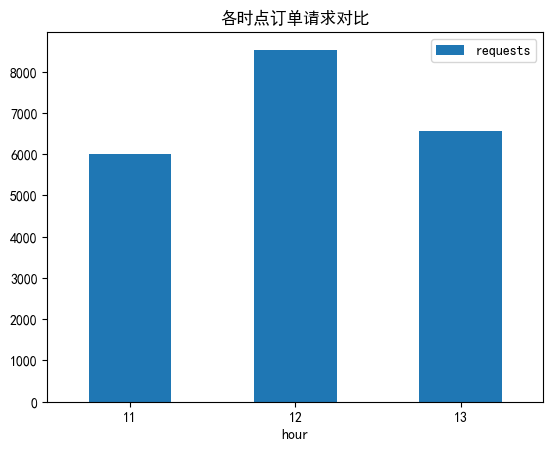

In [19]:
# 绘制各时点订单请求柱状图
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus'] = False

req_hour.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('各时点订单请求对比')
plt.show()

- 可见，在11、12、13这三个时间点内，12点用户发起订单的需求是最大的，其次是13点、11点。
- 司机运营平台应考虑加大该时点车辆供应。

##### 2.2 订单量最多的日期

In [22]:
req_date = city.groupby(['date'], as_index=True).agg({'requests': 'sum'})
req_date.sort_values('date').head()

,requests
date,
2013-09-01,206
2013-09-02,604
2013-09-03,238
2013-09-04,199
2013-09-05,782


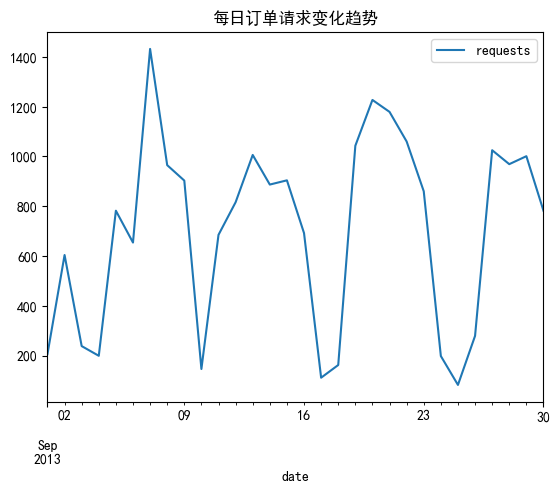

In [23]:
# 绘制订单请求数随日期变化的折线图
req_date.plot(kind='line')
plt.title('每日订单请求变化趋势')
plt.show()

- 单月订单请求数随日期的变化呈周期性变化，我们猜测4个峰值分别对应4个周末，周末用户出行需求较大。
- 经验证发现猜想与数据吻合，因此**司机运营平台应考虑加大周末、节假日的车辆供给**。

##### 2.3 各时段订单完成率

In [24]:
com_hour = city.groupby(['hour'], as_index=False).agg({'requests': 'sum', 'trips': 'sum'})
com_hour['rate'] = com_hour['trips']/com_hour['requests']
com_hour

,hour,requests,trips,rate
0,11,6008,4550,0.757324
1,12,8530,5850,0.685815
2,13,6559,3085,0.470346


- 13点订单需求较多，但订单完成率仅47%，说明较多订单没有得到及时响应。
- 客运部应重点关注13点订单响应时长，排查具体原因。

##### 2.4 单月每日订单完成率

In [25]:
com_date = city.groupby(['date'], as_index=True).agg({'requests': 'sum', 'trips': 'sum'})
com_date['rate'] = com_date['trips']/com_date['requests']
com_date.sort_values('date').head()

,requests,trips,rate
date,,,
2013-09-01,206,146,0.708738
2013-09-02,604,487,0.806291
2013-09-03,238,83,0.348739
2013-09-04,199,102,0.512563
2013-09-05,782,532,0.680307


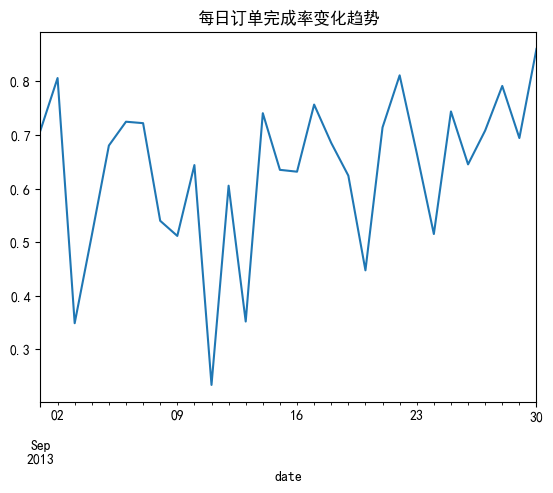

In [26]:
# 绘制订单完成率随日期变化的折线图
com_date.rate.plot(kind='line')
plt.title('每日订单完成率变化趋势')
plt.show()

- 单月每日订单完成率规律不太明显，但几个估值基本都出现在周末附近，说明客户出行需求的提升可能导致响应率的降低。

##### 2.5 顾客等待时间

In [27]:
import numpy as np

eta_hour = city.groupby(['hour'], as_index=True).agg({'pETA': np.mean, 'aETA': np.mean})
eta_hour

,pETA,aETA
hour,,
11,5.397333,6.611000
12,5.860000,7.253333
13,6.018333,7.732667


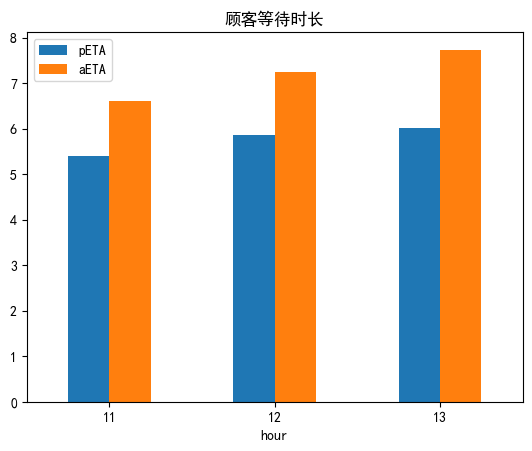

In [28]:
# 绘制顾客等待时长复合柱状图
eta_hour.plot(kind='bar')
plt.title('顾客等待时长')
plt.xticks(rotation=0)
plt.show()

- 以上可见，无论哪个时点，用户实际等待时长均明显大于用户预计等待时长。
- 各时点用户等待时长差异不明显，但13点最高。
- **客运部一方面应提升用户预计等待时长的准确性，另一方面优化平台派单逻辑等。**

##### 2.6 司机在忙率

In [29]:
city['busy'] = city['supply hours']*city['utiliz']
city.head()

,date,hour,requests,trips,supply hours,average minutes of trips,pETA,aETA,utiliz,busy
0,2013-09-01,11,79,55,42.63,20.43,5.51,7.19,0.479240,20.43
1,2013-09-01,12,73,41,36.43,15.53,5.48,8.48,0.426297,15.53
2,2013-09-01,13,54,50,23.02,17.76,5.07,8.94,0.771503,17.76
3,2013-09-02,11,193,170,64.20,31.47,5.31,6.55,0.490187,31.47
4,2013-09-02,12,258,210,80.28,38.68,4.94,6.08,0.481814,38.68


In [30]:
busy_hour = city.groupby(['hour'], as_index=False).agg({'supply hours': 'sum', 'busy': 'sum'})
busy_hour['utiliz'] = busy_hour['busy']/busy_hour['supply hours']
busy_hour

,hour,supply hours,busy,utiliz
0,11,1660.01,768.51,0.462955
1,12,1818.03,1115.28,0.613455
2,13,1274.60,730.83,0.573380


- 12点司机在忙总时长最长，在忙率也最高，用户订单请求也最多，说明车辆空闲数量偏少

##### 2.7 订单时长

In [31]:
trip_min = city.groupby(['hour'], as_index=False).agg({'average minutes of trips': np.mean})
trip_min

,hour,average minutes of trips
0,11,25.617
1,12,37.176
2,13,24.361


- 12点用户订单需求较多，同时订单时长最长，说明这个时间点是一个非常重要的时间点。

In [32]:
supply_hour = city.groupby(['hour'], as_index=False).agg({'supply hours': np.mean})
supply_hour

,hour,supply hours
0,11,55.333667
1,12,60.601000
2,13,42.486667


- 13点订单量也较大，此时点司机服务时长较短。
- **为优化用户出行体验，司机运营平台可联合客运部可考虑此时段尽量分配总服务时长较长的司机来接单（经验较为丰富）。**